# **Ujian Akhir Praktikum - Machine Learning**

Mounting - Base on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Imports And Requirements**

In [2]:
#Organizing Data Structures
import os
import shutil

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

#Visualization
import matplotlib.pyplot as plt

## **Dataset Structures**

#### Unzip

In [3]:
# prompt: Unzip from path i choose into folder

import zipfile

# Path to the zip file
zip_file_path = "/content/drive/MyDrive/UAP_4BURUNG/4KelasBurung.zip"
# Folder to extract to
extract_path = "/content/drive/MyDrive/UAP_4BURUNG/4Burung_UNZIP"


# Create the extract folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully unzipped {zip_file_path} to {extract_path}")
except FileNotFoundError:
  print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully unzipped /content/drive/MyDrive/UAP_4BURUNG/4KelasBurung.zip to /content/drive/MyDrive/UAP_4BURUNG/4Burung_UNZIP


#### Resize Image & Convert

In [6]:
import os
from PIL import Image
import shutil

# Path where you extracted the images
desired_path = "/content/drive/MyDrive/UAP_4BURUNG/4Burung_UNZIP"  # Extracted folder
desired_path_2 = '/content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE'  # New folder for resized images

# Function to copy and reshape images
def copy_and_reshape_images(base_path, desired_path_2, target_size=(224, 224)):
    # Ensure the desired path exists
    if not os.path.exists(desired_path_2):
        os.makedirs(desired_path_2)

    # Iterate through each class folder in the base path
    for cls in os.listdir(base_path):
        cls_folder = os.path.join(base_path, cls)

        if os.path.isdir(cls_folder):
            # Create the class folder in the new path
            dest_folder = os.path.join(desired_path_2, cls)
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)

            # Iterate through each image in the class folder
            for img_file in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_file)

                if os.path.isfile(img_path):
                    try:
                        # Open the image
                        with Image.open(img_path) as img:
                            # Always convert to RGB mode
                            img = img.convert('RGB')

                            # Resize the image
                            img_resized = img.resize(target_size)

                            # Save the resized image in the new folder
                            resized_img_path = os.path.join(dest_folder, img_file)
                            img_resized.save(resized_img_path)
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print("All conversion and reshaping done")

# Execute the function to copy and reshape images
copy_and_reshape_images(desired_path, desired_path_2)


All conversion and reshaping done


### **Splitting & Verifying**

a. checking

In [9]:
import os

# Original dataset path
original_path = '/content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE'

# Walk through the original dataset to display information
for root, dirs, files in os.walk(original_path):
    print(f"Root: {root}")
    print(f"First 5 Files: {files[:5]}")
    print(f"Total Files: {len(files)}")
    print("-" * 40)

# Extract class names from folder names inside the original path
class_names = [d for d in os.listdir(original_path) if os.path.isdir(os.path.join(original_path, d))]
print("Detected Classes (Folders):", class_names)

# Validate each class folder and display summary
for class_name in class_names:
    class_path = os.path.join(original_path, class_name)
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    print(f"Class: {class_name}, Total Files: {len(files)}, First 5 Files: {files[:5]}")


Root: /content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE
First 5 Files: []
Total Files: 0
----------------------------------------
Root: /content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE/Common_Kingfisher
First 5 Files: ['ML102292211.jpg', 'ML105174361.jpg', 'ML105517741.jpg', 'ML105728601.jpg', 'ML109437561.jpg']
Total Files: 924
----------------------------------------
Root: /content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE/Gray_Wagtail
First 5 Files: ['ML100275401.jpg', 'ML100917611.jpg', 'ML101679951.jpg', 'ML102155161.jpg', 'ML104201681.jpg']
Total Files: 926
----------------------------------------
Root: /content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE/Hoopoe
First 5 Files: ['ML100106251.jpg', 'ML100111251.jpg', 'ML100330031.jpg', 'ML102299541.jpg', 'ML102299591.jpg']
Total Files: 924
----------------------------------------
Root: /content/drive/MyDrive/UAP_4BURUNG/4Burung_RESIZE/House_Crow
First 5 Files: ['ML100356141.jpg', 'ML101134201.jpg', 'ML101254211.jpg', 'ML101254231.jpg'

b. Perform Splitting

In [10]:
# Path to save the split datasets
splitted_path = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized'

# Split Ratios
split_ratios = (0.7, 0.2, 0.1)  # Train, Val, Test

# Check if the splitted_path exists and delete it if it does
if os.path.exists(splitted_path):
    shutil.rmtree(splitted_path)

# Create train, val, and test folders dynamically
folders = ['train', 'val', 'test']
for folder in folders:
    for class_name in class_names:
        os.makedirs(os.path.join(splitted_path, folder, class_name), exist_ok=True)

# Perform the split for each class
for class_name in class_names:
    class_path = os.path.join(original_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Split into train, val, test
    train_images, test_images = train_test_split(images, test_size=(1 - split_ratios[0]), random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=(split_ratios[2] / (split_ratios[1] + split_ratios[2])), random_state=42)

    # Copy files into the new folder structure
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(splitted_path, 'train', class_name, image))
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(splitted_path, 'val', class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(splitted_path, 'test', class_name, image))

print("Dataset split completed! The split datasets are saved in:", splitted_path)


Dataset split completed! The split datasets are saved in: /content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized


c. Verifying

In [11]:
import os

# Paths
splitted_path = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized'
folders = ['train', 'val', 'test']

# Automatically get class names based on subdirectories in the 'train' folder
train_dir = os.path.join(splitted_path, 'train')
class_names = [class_name for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))]

# Verify the class names detected
print(f"Detected classes: {class_names}")

# Check if the base split folders exist
for folder in folders:
    folder_path = os.path.join(splitted_path, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: The {folder} folder does not exist at {splitted_path}. Please check the path.")
    else:
        print(f"--- {folder.upper()} SPLIT ---")
        # Check each class within the folder
        for class_name in class_names:
            class_path = os.path.join(folder_path, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: The {class_name} class folder is missing in the {folder} split.")
            else:
                # Count and display the number of files in each class folder
                total_files = len(os.listdir(class_path))
                print(f"Class: {class_name}, Total Files in {folder}: {total_files}")


Detected classes: ['Common_Kingfisher', 'Gray_Wagtail', 'Hoopoe', 'House_Crow']
--- TRAIN SPLIT ---
Class: Common_Kingfisher, Total Files in train: 646
Class: Gray_Wagtail, Total Files in train: 648
Class: Hoopoe, Total Files in train: 646
Class: House_Crow, Total Files in train: 646
--- VAL SPLIT ---
Class: Common_Kingfisher, Total Files in val: 185
Class: Gray_Wagtail, Total Files in val: 185
Class: Hoopoe, Total Files in val: 185
Class: House_Crow, Total Files in val: 185
--- TEST SPLIT ---
Class: Common_Kingfisher, Total Files in test: 93
Class: Gray_Wagtail, Total Files in test: 93
Class: Hoopoe, Total Files in test: 93
Class: House_Crow, Total Files in test: 93


## **EDA : Simple Exploration**

#### **Class Distribution Each Splitted Dataset**

Detected Classes (Folders): ['Common_Kingfisher', 'Gray_Wagtail', 'Hoopoe', 'House_Crow']


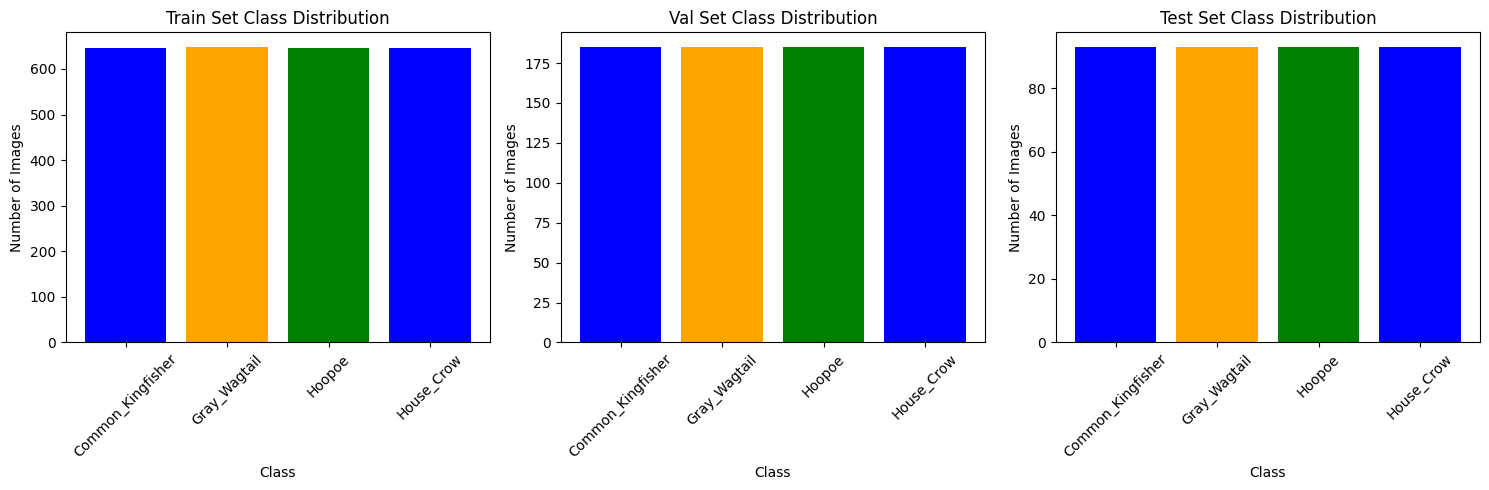

In [12]:
import os
import matplotlib.pyplot as plt

# Step 1: Define the path for the split dataset (you've already uploaded this)
splitted_path = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized'

# Step 2: Get class names dynamically (based on folder names in the split dataset)
# Assuming the 'train', 'val', 'test' folders are already inside 'splitted_path'
train_dir = os.path.join(splitted_path, 'train')
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

print("Detected Classes (Folders):", class_names)

# Step 3: Plotting function for class distribution
def plot_class_distribution(splitted_path, class_names, folders=['train', 'val', 'test']):
    fig, ax = plt.subplots(1, len(folders), figsize=(15, 5))

    for i, folder in enumerate(folders):
        folder_path = os.path.join(splitted_path, folder)

        # Step 4: Count the number of images for each class in the folder
        class_counts = {class_name: len(os.listdir(os.path.join(folder_path, class_name))) for class_name in class_names}

        # Plotting the distribution
        ax[i].bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green'])
        ax[i].set_title(f'{folder.capitalize()} Set Class Distribution')
        ax[i].set_xlabel('Class')
        ax[i].set_ylabel('Number of Images')

        # Rotate x-labels for readability
        ax[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Step 5: Call the function to plot the class distributions
plot_class_distribution(splitted_path, class_names)


#### **Shape : Each Class Shape**

In [13]:
from tensorflow.keras.preprocessing import image
import os

# Function to get the shape of an image for any dataset split (train, val, test)
def get_image_shape(class_name, split='train', base_path=None):
    """
    Get the shape of an image from a specific class and dataset split.
    :param class_name: The class name (folder name) in the dataset
    :param split: The dataset split ('train', 'val', 'test')
    :param base_path: The base path of the dataset where the 'train', 'val', 'test' folders are located
    :return: Shape of the image (height, width, channels)
    """
    # Get the path to the class folder in the specific split (train, val, test)
    folder_path = os.path.join(base_path, split, class_name)

    # Get the list of image files in the class folder
    image_files = os.listdir(folder_path)

    # Select the first image as a sample
    sample_image_path = os.path.join(folder_path, image_files[0])

    # Load and convert the image to array
    img = image.load_img(sample_image_path)
    img_array = image.img_to_array(img)

    # Return the shape of the image
    return img_array.shape

# Base path where the dataset is stored
splitted_path = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized'

# Get the class names dynamically
class_names = [d for d in os.listdir(os.path.join(splitted_path, 'train')) if os.path.isdir(os.path.join(splitted_path, 'train', d))]

# Get the image dimensions of a sample from each class in the 'train' split
for class_name in class_names:
    image_shape = get_image_shape(class_name, 'train', splitted_path)
    print(f"Class: {class_name}, Image Shape: {image_shape}")


Class: Common_Kingfisher, Image Shape: (224, 224, 3)
Class: Gray_Wagtail, Image Shape: (224, 224, 3)
Class: Hoopoe, Image Shape: (224, 224, 3)
Class: House_Crow, Image Shape: (224, 224, 3)


#### **Sample Image : Each Class**

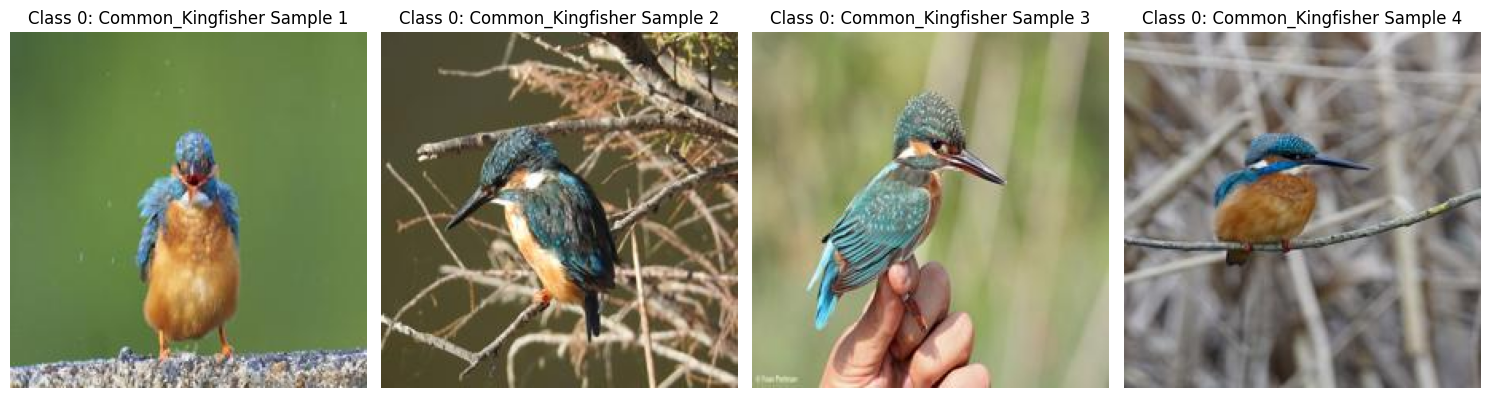

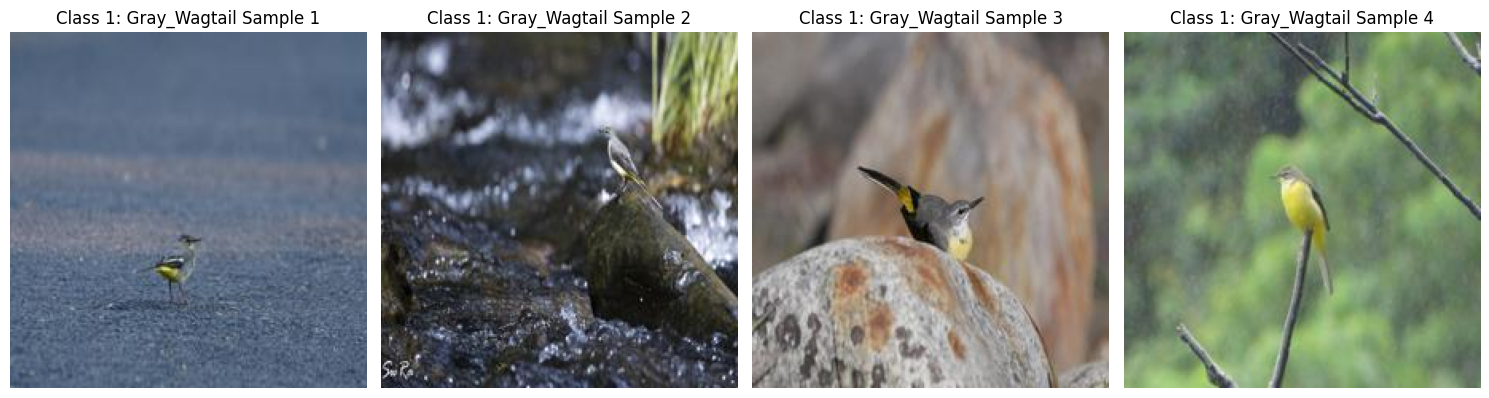

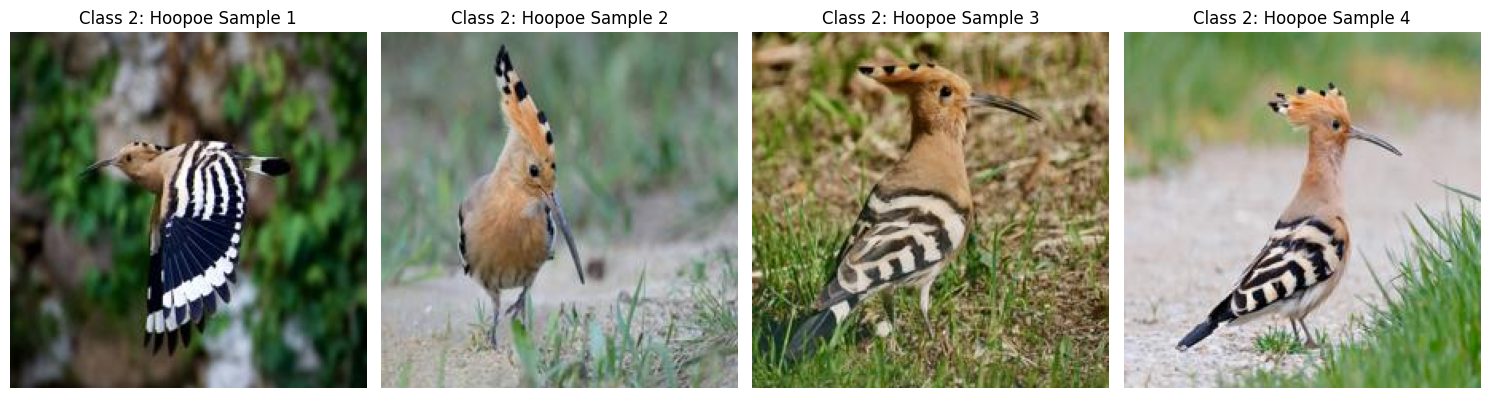

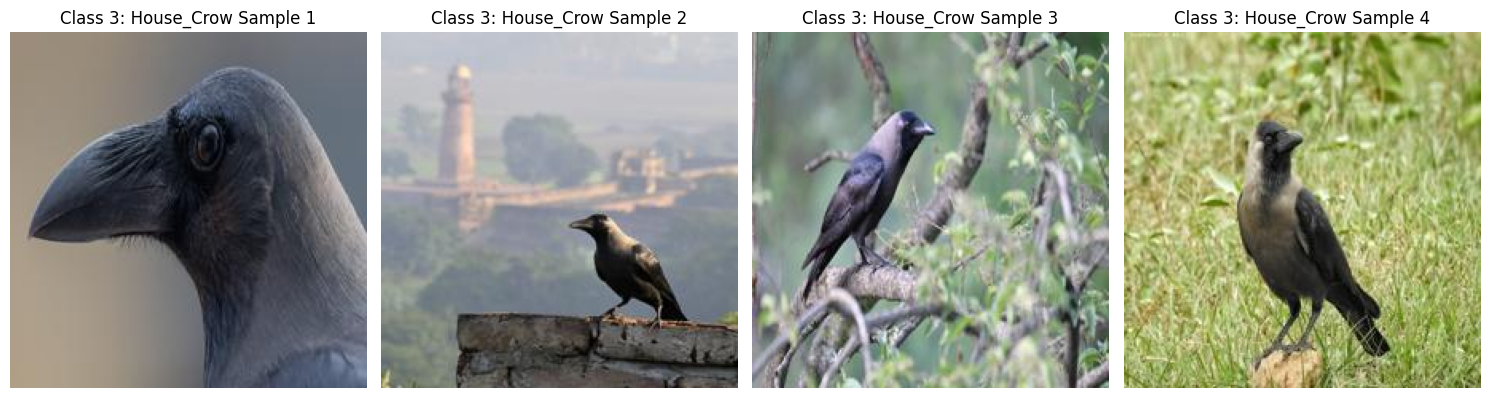

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Directory paths for different splits
train_dir = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized/train/'
val_dir = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized/val/'
test_dir = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized/test/'

# Function to display a few sample images from a class (using indices as class names)
def display_sample_images(class_index, dataset='train', num_samples=3):
    # Select the appropriate directory based on the dataset split
    dataset_dir = train_dir if dataset == 'train' else \
                  val_dir if dataset == 'val' else \
                  test_dir

    # List the class folder names (directories) and sort them to ensure consistent indexing
    class_folders = sorted(os.listdir(dataset_dir))

    # Check if the class_index is valid
    if class_index >= len(class_folders):
        raise ValueError("Invalid class_index. Class index is out of range.")

    # Get the class name using the index
    class_name = class_folders[class_index]

    # List the files in the class folder
    image_files = os.listdir(os.path.join(dataset_dir, class_name))

    # Plotting the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        img_path = os.path.join(dataset_dir, class_name, image_files[i])  # Take first few samples
        img = image.load_img(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Class {class_index}: {class_name} Sample {i+1}")

    plt.tight_layout()
    plt.show()

# Display samples from each class (using indices for class names)
num_classes = len(os.listdir(train_dir))  # Number of classes based on train directory
for class_index in range(num_classes):
    display_sample_images(class_index, 'train', num_samples=4)


## **Preprocessing**

In [15]:
# Parameters
img_height = 224
img_width = 224
batch_size = 64

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

splitted_path = '/content/drive/MyDrive/UAP_BURUNG/4Burung_Splitted_Resized'

# Paths
train_dir = os.path.join(splitted_path, 'train')
val_dir = os.path.join(splitted_path, 'val')
test_dir = os.path.join(splitted_path, 'test')

# Create an instance of ImageDataGenerator for training (with augmentation)
augment_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=30,       # Randomly rotate images by up to 30 degrees
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# For validation and test, only rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories to ImageDataGenerators
train_generator = augment_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='categorical', # Multi-class classification
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2586 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Found 372 images belonging to 4 classes.


## **Model & Evaluation Function**

#### 1. MobileNetV2

In [17]:
#Parameters Model
epochs = 10
class_names = list(train_generator.class_indices.keys())

In [18]:
# Load the pre-trained MobileNetV2 model without the top layer (head)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Dropout to reduce overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer with number of classes
])

# Evaluate the model
print("Model Summary:")
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Assuming train_generator and val_generator are defined as your data generators
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size,
                    callbacks=[early_stop])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7532 - loss: 0.6003 - val_accuracy: 0.9608 - val_loss: 0.1213
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 974ms/step - accuracy: 0.9458 - loss: 0.1676 - val_accuracy: 0.9757 - val_loss: 0.0956
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 930ms/step - accuracy: 0.9539 - loss: 0.1322 - val_accuracy: 0.9703 - val_loss: 0.0902
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 932ms/step - accuracy: 0.9719 - loss: 0.0865 - val_accuracy: 0.9770 - val_loss: 0.0768
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 907ms/step - accuracy: 0.9699 - loss: 0.0780 - val_accuracy: 0.9770 - val_loss: 0.0724
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9759 - loss: 0.0752 - val_accuracy: 0.9797 - val_loss: 0.0749
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 78s 913ms/step - accuracy: 0.9728 - loss: 0.0685 - val_accuracy: 0.9595 - val_loss: 0.1163
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 894ms/step - accuracy: 0.9759 - loss: 0.0671 - val_accuracy: 0.9757 - va

#### Evaluation & Visualization

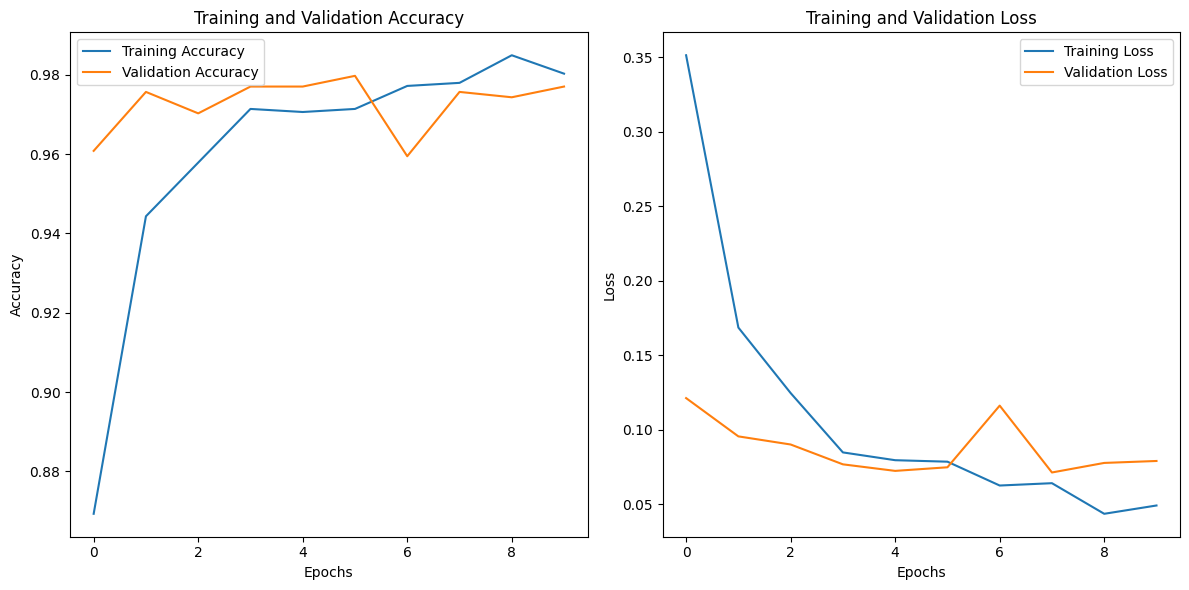

In [22]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9734 - loss: 0.0856
Test Loss: 0.094248928129673
Test Accuracy: 0.9650537371635437


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step
Classification Report:
                   precision    recall  f1-score   support

Common_Kingfisher       0.97      0.99      0.98        93
     Gray_Wagtail       0.94      0.97      0.95        93
           Hoopoe       0.98      0.97      0.97        93
       House_Crow       0.98      0.94      0.96        93

         accuracy                           0.97       372
        macro avg       0.97      0.97      0.97       372
     weighted avg       0.97      0.97      0.97       372



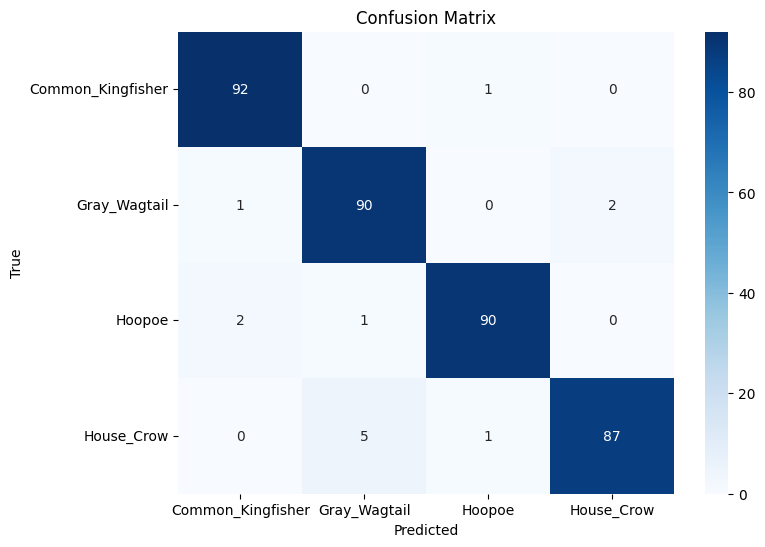

In [24]:
# Predict on test data
test_predictions = model.predict(test_generator, verbose=1)
test_predictions = np.argmax(test_predictions, axis=-1)  # Convert predictions to class labels
true_labels = test_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, test_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [26]:
# Save the trained model to a .h5 file
model.save('/content/drive/MyDrive/UAP_4BURUNG/BurungMobileNetV2.h5')

In [1]:
from collections import Counter
class_distribution = Counter(train_generator.classes)
print(class_distribution)

NameError: name 'train_generator' is not defined